### 偽回測：計算每日震幅，做為資料標示Tag用，最大最小分類，分合併盤、日盤、夜盤
目前是產生每日的走勢圖片供策略開發
但是圖片我處理的很不好，有更好的方法歡迎分享
backtrader官網 https://www.backtrader.com/docu/quickstart/quickstart/

In [1]:
from __future__ import (absolute_import, division, print_function, unicode_literals)

# 匯入backtrader模組
import backtrader as bt
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import datetime as dt
import sqlite3
import datetime

dbName = r"C:\Users\kevin\Desktop\機器人理財\robot\data\kbars.db"
# dbName = input('kbar資料庫路徑:')


In [2]:
#從資料庫載入資料
def load_data(contractName, thisdate):
    start_date = pd.to_datetime(thisdate)
    end_date = start_date + pd.Timedelta(days=1)

    # include the time in the date string
    startday = f'"{start_date.strftime("%Y-%m-%d")} 08:45:00"'
    endday = f'"{end_date.strftime("%Y-%m-%d")} 05:00:00"'

    dbName = r"C:\Users\kevin\Desktop\機器人理財\robot\data\kbars.db"
    
    with sqlite3.connect(dbName) as conn:
        query = (f'SELECT "ts" as datetime, "Volume" as volume, "Close" as close, '
             f'"Open" as open, "High" as high, "Low" as low '
             f'FROM {contractName} '
             f'WHERE "ts" >= {startday} AND "ts" <= {endday}')

    df = pd.read_sql_query(query, conn, parse_dates=['datetime'])

    return df

## 回測策略(偽策略)

In [3]:
class MaxMinMarked(bt.Strategy):
    params = (
        ('pmode',1),
        ('maxDay', 1),
        ('minDay', 5)
    )

    def __init__(self):        
        self.dataclose = self.datas[0].close
        self.ordered = 0

    def next(self):
        #偽策略，已經知道當日最高最低點，直接下定價單
        if self.ordered == 0:            
            self.buy(exectype=bt.Order.Limit, price=self.params.minDay)
            self.sell(exectype=bt.Order.Limit, price=self.params.maxDay)
            self.ordered = 1
    
    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.datetime(0)
        if (self.p.pmode == 1):
            print('%s, %s' % (dt.strftime("%Y-%m-%d %H:%M:%S"), txt))


    #訂單狀態改變時發出的通知
    def notify_order(self, order):
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

    #交易狀態改變時發出的通知（「買->賣」或「賣->買」完成，即為一個交易）
    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' % (trade.pnl, trade.pnlcomm))
                            
                            
    #模擬終止前的動作:print出結果
    def stop(self):
        final_portfolio_value = self.broker.getvalue()
        initial_cash = self.broker.startingcash
        self.profit = round(final_portfolio_value - initial_cash)
        print(f'Profit: {self.profit}')

In [4]:
#在圖上畫出買入賣出，我是透過chatgpt問的，做得不好，還需要更熟悉畫圖模組，如果有好的方法請推薦
class PositionSize(bt.Observer):
    lines = ('Buy', 'Sell')
    
    plotinfo = dict(plot=True, subplot=True)
    plotlines = dict(
        position_size_positive=dict(_plotskip='True', marker='o', markersize=2.0, color='blue', fillstyle='full'),
        position_size_negative=dict(_plotskip='True', marker='o', markersize=2.0, color='red', fillstyle='full')
    )
    
    def next(self):
        position_size = self._owner.position.size
        if position_size >= 0:
            self.lines.Buy[0] = position_size
            self.lines.Sell[0] = 0
        else:
            self.lines.Buy[0] = 0
            self.lines.Sell[0] = position_size


## 函數：用來跑回測
因為目標是當日冲，每天分開跑回測

In [5]:
def run_cerebro(contractName, date_range, act_val):
    results = pd.DataFrame()

    for date in date_range:
        weekday = date.weekday()
        print(f'Starting 周{weekday+1}: {date.date()} {contractName}')

        #下載資料  
        df = load_data(contractName, date)

        if df.empty:
            print(f"*****{date.strftime('%w_%Y-%m-%d')} DataFrame is empty")
            
        else:
            #宣告回測
            cerebro = bt.Cerebro(stdstats=False)

            df.set_index('datetime', inplace=True)
            df['datetime'] = df.index
            
            # 在DataFrame中進行時間分割
            day_session = df.between_time('08:45', '13:45')
            night_session = df.between_time('15:00', '05:00')

            # 根據 act_val 選擇對應的數據
            if act_val == "Day":
                df = day_session
            elif act_val == "Night":
                df = night_session
                
            # 计算最大值、最小值和方向
            max_val = df['high'].max()
            min_val = df['low'].min()
            dir_val = 1 if df['low'].idxmin() < df['high'].idxmax() else -1
            diff_abs = abs(max_val - min_val)
            diff_str = "{:04d}".format(int(diff_abs))
            
            #添加策略
            cerebro.addstrategy(
                MaxMinMarked, 
                maxDay=max_val,
                minDay=min_val
            )
            
            #添加observer
            cerebro.addobserver(PositionSize)
            cerebro.addobserver(bt.observers.Value)
            cerebro.addobserver(bt.observers.BuySell, barplot=True, bardist=0.0001)

            #資料餵入回測
            data = bt.feeds.PandasData(dataname=df, open='open', high='high', low='low', close='close', volume='volume', datetime='datetime', timeframe=bt.TimeFrame.Minutes)
            cerebro.adddata(data)

            cerebro.broker.setcash(100000.0)
            #小台的設法
            cerebro.broker.setcommission(commission=34, margin=46000.0, mult=50.0, commtype=bt.CommInfoBase.COMM_FIXED)
            cerebro.addsizer(bt.sizers.FixedSize, stake=1)

            print(f'Starting {dir_val}: {date.date()}')

            res = cerebro.run()

            print(f'Profit: {res[0].profit}')
            profit = res[0].profit

            results.at[date.strftime('%Y-%m-%d'), 'profit'] = diff_str

            #因為跑的時候就是會秀出圖片，非常耗記憶體，放到py檔又要一個一個關，無法自動跑，這個需要調整
            figures = cerebro.plot(plotter=MyPlot(),style='line',plotlinelabels=False, barup='red', bardown='green', figkwargs=dict(figsize=(16, 9)), subplot=True, plotdist=0.0001)
            #figures = cerebro.plot(style='line',plotlinelabels=False, barup='red', bardown='green', figkwargs=dict(figsize=(16, 9)), subplot=True, plotdist=0.0001)
            save_figures(figures, date, diff_str, act_val)

    return results

#### 批量畫圖處理(處理得不好)

In [6]:
#遮掉畫圖用的
from backtrader import plot
class MyPlot(plot.Plot):
    def show(self):
        pass  # 覆盖show方法，不执行任何操作，因此不会显示图像

In [7]:
#v你可能在 Jupyter Notebook 中运行代码，而 Jupyter Notebook 有自己的图形大小设置。
#你可以使用 %matplotlib inline 魔法命令，并在其后设置图形大小，如下所示：
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 6)

### 存圖片(重點)
#### 圖片目錄要先建  .\pic\AllDay  .\pic\Day .\pic\Night
#### 圖片X軸要有時間刻度
要修改 \Lib\site-packages\backtrader\plot.py
我的是262行 
```python
for ax in laxis:
    self.mpyplot.setp(ax.get_xticklabels(), visible=True)
```
##### 印象要重開
https://community.backtrader.com/topic/3113/date-axis-does-not-show-up-on-plot/2

In [8]:
def save_figures(figures, date, profit, act_val):
    plt.ioff()
    
    for i, fig in enumerate(figures[0]):
        ax0 = fig.get_axes()[0]

        fig.autofmt_xdate()
        fig.tight_layout()
        
        file_name = f".\pic\{act_val}\{profit}_{date.strftime('%w_%Y-%m-%d')}.PNG"
        print(file_name)
        fig.savefig(file_name, dpi=300)

        # 關閉當前處理的圖像
        plt.close(fig)


## 主程式

Starting 周1: 2023-07-17 TXFR1
Starting 1: 2023-07-17
2023-07-17 11:11:00, SELL EXECUTED, 17345.00
Profit: 566
Profit: 566


<IPython.core.display.Javascript object>


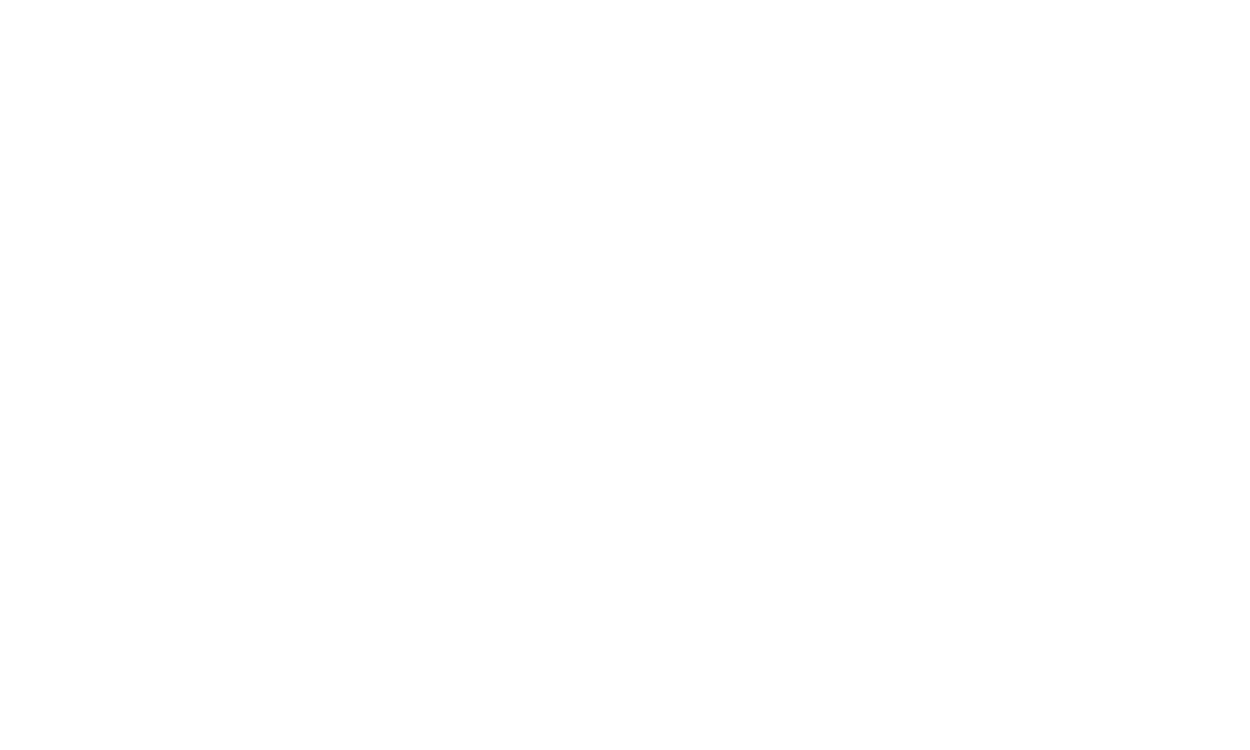

.\pic\AllDay\0116_1_2023-07-17.PNG
Starting 周2: 2023-07-18 TXFR1
Starting -1: 2023-07-18
2023-07-18 09:25:00, SELL EXECUTED, 17386.00
2023-07-18 09:46:00, BUY EXECUTED, 17152.00
2023-07-18 09:46:00, OPERATION PROFIT, GROSS 11700.00, NET 11632.00
Profit: 11632
Profit: 11632
.\pic\AllDay\0234_2_2023-07-18.PNG
Starting 周3: 2023-07-19 TXFR1
Starting -1: 2023-07-19
2023-07-19 09:01:00, SELL EXECUTED, 17325.00
2023-07-20 02:25:00, BUY EXECUTED, 17011.00
2023-07-20 02:25:00, OPERATION PROFIT, GROSS 15700.00, NET 15632.00
Profit: 15632
Profit: 15632
.\pic\AllDay\0314_3_2023-07-19.PNG
Starting 周4: 2023-07-20 TXFR1
Starting -1: 2023-07-20
2023-07-20 09:44:00, SELL EXECUTED, 17150.00
2023-07-21 03:24:00, BUY EXECUTED, 16834.00
2023-07-21 03:24:00, OPERATION PROFIT, GROSS 15800.00, NET 15732.00
Profit: 15732
Profit: 15732
.\pic\AllDay\0316_4_2023-07-20.PNG
Starting 周5: 2023-07-21 TXFR1
Starting 1: 2023-07-21
2023-07-21 09:14:00, BUY EXECUTED, 16816.00
2023-07-21 11:31:00, SELL EXECUTED, 16984.00
2

In [9]:
if __name__ == '__main__':
    date_range = pd.date_range(start='2023-07-17', end='2023-7-23')
    contractName='TXFR1'
    
    #分別產生 合併盤、日盤、夜盤
    allDay_results = run_cerebro(contractName, date_range, "AllDay")
    day_results = run_cerebro(contractName, date_range, "Day")
    night_results = run_cerebro(contractName, date_range, "Night")

    # 將結果合併到一個 DataFrame
    results_df = pd.concat([allDay_results, day_results, night_results], axis=1, keys=["AllDay", "Day", "Night"])

    # 儲存結果
    results_df.to_csv('backtest_results.csv')

### 工具：輸出PY檔

In [ ]:
with open('class.py', 'w', encoding='UTF-8') as f:
    for i in range(1, 9):
        f.write(In[i] + '\n')